In [ ]:
# Colab setup

# from google.colab import drive
# drive.mount("/content/drive/")

# %cd "/content/drive/MyDrive/PACS/APSC_project/bayesian_network/examples/3_autoencoder"

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [ ]:
# Import libraries

import numpy as np
from dlroms import *
from dlroms.dnns import *
import matplotlib.pyplot as plt
import torch
from dolfin import *
import time

In [ ]:
# Setup

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(0) # TODO: change seed initialization

class Args:
	def __init__(self, n_snapshots, input_dir, output_dir, checkpoint_dir, verbose):
		self.n_snapshots = n_snapshots
		self.input_dir = input_dir
		self.output_dir = output_dir
		self.checkpoint_dir = checkpoint_dir
		self.verbose = verbose

args = Args(1200, 'snapshots', 'outputs', 'checkpoints', True)

In [ ]:
# Domain and mesh definition

mesh = fe.unitsquaremesh(100, 100)
V = fe.space(mesh, 'CG', 1)
Nh = V.dim()

In [ ]:
# Load snapshots

path_train = os.path.join(args.input_dir, 'snapshots_train_H_' + str(args.n_snapshots) + '.npz')
if not os.path.exists(path_train):
	print(f"Training snapshots not found at {path_train}.")
	exit()
data_train = np.load(path_train)
N_train = data_train['mu'].shape[0]
mu_train, u_train = data_train['mu'].astype(np.float32), data_train['u'].astype(np.float32)
mu_train, u_train = torch.tensor(mu_train).to(device), torch.tensor(u_train).to(device)

path_test = os.path.join(args.input_dir, 'snapshots_test.npz')
if not os.path.exists(path_test):
	print(f"Test snapshots not found at {path_test}.")
	exit()
data_test = np.load(path_test)
N_test = data_test['mu'].shape[0]
mu_test, u_test = data_test['mu'].astype(np.float32), data_test['u'].astype(np.float32)
mu_test, u_test = torch.tensor(mu_test).to(device), torch.tensor(u_test).to(device)

In [ ]:
# Traning architecture

m = 16
k = 4

# torch.set_default_dtype(torch.float32)

psi_prime = Dense(Nh, 4, activation=None)

psi = Dense(4, 100 * m) + \
		Reshape(4 * m, 5, 5) + \
		Deconv2D(11, (4 * m, 2 * m), 2) + \
		Deconv2D(10, (2 * m, m), 2) + \
		Deconv2D(11, (m, 1), 2, activation=None) + \
		Reshape(-1)

phi = Dense(4, 50 * k) + \
		Dense(50 * k, 50 * k) + \
		Dense(50 * k, 4, activation=None)

print("Trainable parameters:")
print(" Encoder:", psi_prime.dof())
print(" Decoder:", psi.dof())
print(" Dense NN:", phi.dof())

Trainable parameters:
 Encoder: 40808
 Decoder: 308993
 Dense NN: 42004


In [ ]:
# Train the full model

dlrom = DLROM(phi, psi, psi_prime) # dense NN + decoder + encoder
# dlrom = DLROM(phi, psi_prime, psi) # dense NN + encoder + decoder (?)

if device.type == 'cuda':
	dlrom.cuda()
else:
	dlrom.cpu()

def loss(true, pred):
	utrue = true
	upred, delta, urecon = pred # unpack the prediction into predicted solution, latent representation error, and reconstructed solution
	return mse(neuclidean)(utrue, upred) + mse(neuclidean)(utrue, urecon) + mse(neuclidean)(0, delta)

def error(true, pred):
	utrue = true
	upred, _, _ = pred
	return mse(neuclidean)(utrue, upred)

dlrom.train((mu_train, u_train), u_train, ntrain=N_train, epochs=300, loss=loss, error=error, verbose=True)

		Train		Test
Epoch 300:	3.68e-05	nan.

>> ETA: 5.83s.

Training complete. Elapsed time: 29 minutes 8.22 seconds.


In [ ]:
# Use the DLROM to predict the full order solution

dlrom.eval()

with torch.no_grad():
  u_train_pred = dlrom(mu_train)

In [ ]:
# Compute the relative error

error_train = torch.norm(u_train - u_train_pred, dim=1) / torch.norm(u_train, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

Relative training error: 7.10%


In [ ]:
# Relative training error (1200, epochs=200): 7.94%
# Relative training error (1200, epochs=300): 7.10%

In [ ]:
# Apply the model to the test set

with torch.no_grad():
  u_test_pred = dlrom(mu_test)

error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative test error: 7.57%


In [ ]:
# Relative test error (1200, epochs=200): 8.35%
# Relative test error (1200, epochs=300): 7.57%

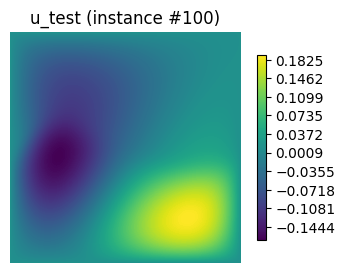

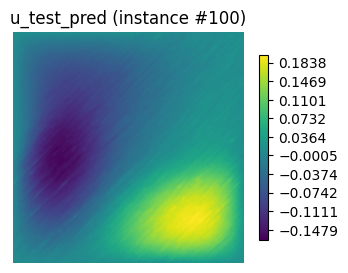

In [ ]:
# Plot some results

index = 100

plt.figure(figsize=(4, 3))
fe.plot(u_test[index, :], V, colorbar=True)
plt.title('u_test (instance #' + str(index) + ')')

plt.figure(figsize=(4, 3))
fe.plot(u_test_pred[index, :], V, colorbar=True)
plt.title('u_test_pred (instance #' + str(index) + ')')

plt.show()

In [ ]:
# Save encoder, decoder, and dense NN

psi_prime.save(os.path.joint(args.checkpoint_dir, 'psi_prime_' + str(args.n_snapshots) + '_' + str(args.n_snapshots)))
psi.save(os.path.joint(args.checkpoint_dir, 'psi_' + str(args.n_snapshots) + '_' + str(args.n_snapshots)))
phi.save(os.path.joint(args.checkpoint_dir, 'phi_' + str(args.n_snapshots) + '_' + str(args.n_snapshots)))

# torch.save(psi_prime.state_dict(), os.path.joint(args.checkpoint_dir, 'psi_prime_' + str(args.n_snapshots) + '_' + str(args.n_snapshots)))
# torch.save(psi.state_dict(), os.path.joint(args.checkpoint_dir, 'psi_' + str(args.n_snapshots) + '_' + str(args.n_snapshots)))
# torch.save(phi.state_dict(), os.path.joint(args.checkpoint_dir, 'phi_' + str(args.n_snapshots) + '_' + str(args.n_snapshots))